In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.interpolate import griddata as gd
from pykrige.ok import OrdinaryKriging
from matplotlib import cm
import netCDF4 as nc
import scipy.io
import glob,csv
from IPython.display import Image
from mpl_toolkits.basemap import Basemap
%matplotlib inline

#Pa_part Interpolation

In [2]:
data=scipy.io.loadmat('/ocean/xiaoxiny/research/findk/All_Arctic-data/WLS/Th_diss.mat')
NEMO_dep=data['NEMO_dep']
Pa_diss=data['Th_diss']
lons=data['lons']
lats=data['lats']

In [150]:
layer=10
x=lons[layer,:]
y=lats[layer,:]
z=Pa_diss[layer,:]
x_ma=np.ma.masked_where(abs(x)<= 1e-200,x)
x_ma=np.ma.masked_where(np.isnan(x_ma),x_ma)
y_ma=np.ma.masked_where(abs(x)<= 1e-200,y)
y_ma=np.ma.masked_where(np.isnan(y_ma),y_ma)
z_ma=np.ma.masked_where(abs(z)<= 1e-200,z)
z_ma=np.ma.masked_where(np.isnan(y_ma),z_ma)

In [151]:
coordinate_name=glob.glob('/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/test/EXP00/coordinates*.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

In [152]:
m = Basemap(projection='npstere',boundinglat=55,lon_0=0,resolution='l')
x_dis,y_dis = m(x_ma, y_ma)
x_lon,y_lat = m(nav_lon, nav_lat)
a,b=m(0,90)

In [153]:
#print x_ma.shape
#print nav_lat[147,50]
#print a,b

In [154]:
xx_lon=np.empty([149,182])
yy_lat=np.empty([149,182])
xx_dis=np.empty([len(x_dis)])
yy_dis=np.empty([len(x_dis)])

for j in range (182):
    for i in range (149):
        
        if nav_lon[i,j]>0:
            b_useless, b = m(nav_lon[i,j],nav_lat[i,j])
            yy_lat[i,j]=2*b-y_lat[i,j]
        else:
            yy_lat[i,j]=y_lat[i,j]

        xx_lon[i,j]=x_lon[i,j]-a
        
xx_lon_ma=np.ma.masked_where(nav_lat<55,xx_lon)
yy_lat_ma=np.ma.masked_where(nav_lat<55,yy_lat)


for k in range (len(xxx_dis)):
        if x_ma[k]>0:
            b_useless, bb = m(x_ma[k],y_ma[k])
            yy_dis[k]=2*bb-y_dis[k]
        else:
            yy_dis[k]=y_dis[k]
        
        xx_dis[k]=x_dis[k]-a
xx_dis=np.ma.masked_where(np.isnan(xx_dis),xx_dis)
yy_dis=np.ma.masked_where(np.isnan(yy_dis),yy_dis)
z_ma=np.ma.masked_where(np.isnan(yy_dis),z_ma)

In [155]:
xxx_dis=xx_dis.compressed()
yyy_dis=yy_dis.compressed()
zzz_ma=z_ma.compressed()
print xxx_dis
print yyy_dis

[  173859.81488695   343931.92437514   458902.5393971    259548.05453378
  -812992.78174402   192614.73013353   210294.99190145    79705.45158206
   333889.80458892  3247796.42867531]
[ 3607947.2198769   3445136.43103712  3253793.19538286  3048888.74957427
  5613123.45045067  3906329.10980752  4089945.6487482   4225175.0764129
  3439221.17042275  3247796.42867531]


In [156]:
OK = OrdinaryKriging(xxx_dis,yyy_dis, zzz_ma, variogram_model='linear', verbose=False, enable_plotting=False)
Pa_interp, ss = OK.execute('points',xx_lon, yy_lat)
Pa_interp=Pa_interp.reshape(149,182)

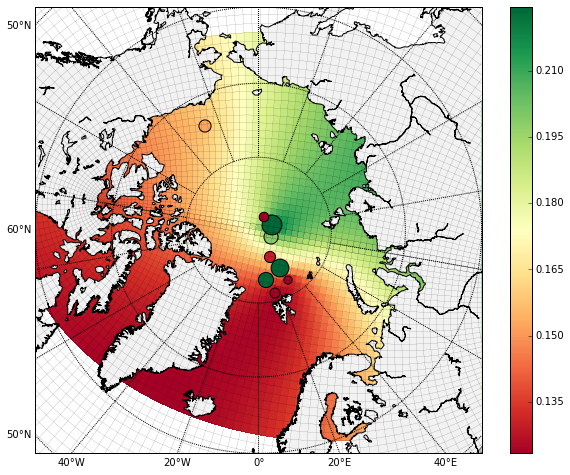

In [165]:
fig=plt.figure(figsize=(10, 10)); ax=plt.gca()
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.95')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

x_maa=x_ma.compressed()
y_maa=y_ma.compressed()
z_maa=z_ma.compressed()

x,y = m(nav_lon, nav_lat)
plt.plot(x,y,x.T,y.T,color='k',linewidth=0.1)
CS = m.pcolor(x[120:-1,:],y[120:-1,:],Pa_interp[120:-1,:],cmap=plt.cm.RdYlGn)
#plt.clim(np.min(z_maa),np.max(z_maa))
CBar = plt.colorbar(CS,shrink=0.8)

for j in range(len(x_maa)):
    x2,y2= m(x_maa[j], y_maa[j])
    cmm = plt.cm.get_cmap('RdYlGn')
    #m.scatter(x2,y2,c=z_maa[j],vmin=np.min(z_maa),vmax=np.max(z_maa),cmap=cmm,s=z_maa[j]*1000)
    m.scatter(x2,y2,c=z_maa[j],vmin=np.min(Pa_interp),vmax=np.max(Pa_interp),cmap=cmm,s=z_maa[j]*1000)
plt.show()

###compare zzz_ma(original data) with Pa_interp

In [166]:
print zzz_ma.max()
print zzz_ma.min()
print zzz_ma

0.392
0.0684489829943
[ 0.12418321  0.08003507  0.06844898  0.10069503  0.14806633  0.197       0.392
  0.09027098  0.317       0.23      ]


In [159]:
print Pa_interp.max()
print Pa_interp.min()

0.224424602001
0.117372836425


##grid(Draft)

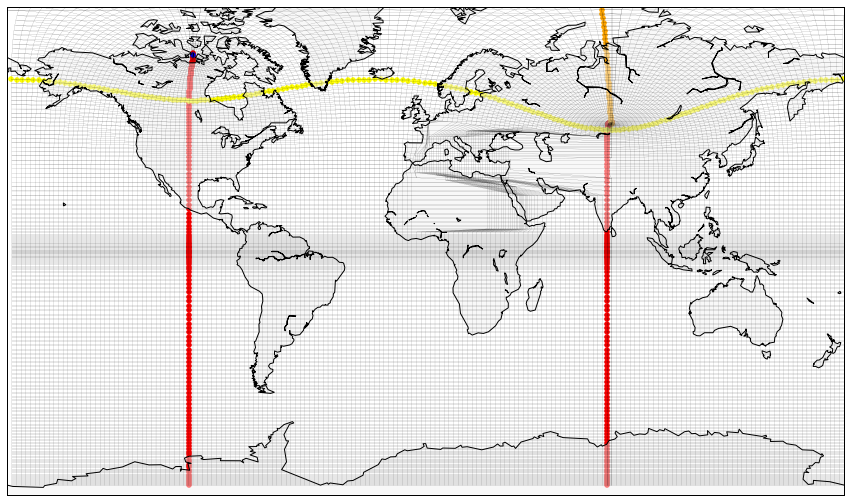

In [63]:
fig=plt.figure(figsize=(15, 10)); 
#m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='l')
m=Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=80,projection='mill')
m.drawcoastlines()
m.fillcontinents(color = '0.95',alpha=0.5)
x_lon,y_lat = m(nav_lon, nav_lat)
plt.plot(x_lon,y_lat,x_lon.T,y_lat.T,color='black',linewidth=0.09)
m.scatter(x_lon[:,0],y_lat[:,0],color='r')
m.scatter(x_lon[:,90],y_lat[:,90],color='r')
#m.scatter(x_lon[0,:],y_lat[0,:],color='orange')
m.scatter(x_lon[-1,0:45],y_lat[-1,0:45],color='orange')
m.scatter(x_lon[120,:],y_lat[120,:],color='yellow')
m.scatter(x_lon[-1,90],y_lat[-1,90],color='blue')

plt.show()